## DATA 621 - NNDL - Homework 1 (by Steven Morse)

**Steven Morse**

### Bonus

**This section provides the detailed derivation of computing backprop with cross-entropy loss (Bonus), and then we answer Questions 1-7.**


We will implement, from scratch, a general neural network framework for multi-class classification, using ReLU hidden units and softmax output, so activations are:

$$
\text{hidden layer: } a_j^l = f(z_j) = \max (0, z_j) \qquad
\text{output layer: } a_j^L = F(z^L)_j = \frac{\exp(z_j^L)}{\sum_i \exp(z_i^L)}
$$

Here we use the usual $z^l = (W^l)^T a^{l-1} + b^l$ where $W^l = [w_{ij}^l]$ represents the weights at layer $l$ such that $w_{ij}^l$ is the weight from output $a_i^{l-1}$ to unit $z_j^l$ and $b^l$ the bias vector at layer $l$.

Using a one-hot encoding for each target $y^{(i)}$, we define the cross-entropy loss at a single datapoint with predicted value $\hat{y} = a^L = F(z^L)$ as

$$
\ell = -\sum_k y_k \log \hat{y}_k
$$

and the objective being to minimize total cross-entropy loss over all training data, i.e.

$$
\hat{W}, \hat{b} = \text{arg}\min_{W,b} -\sum_{i=1}^N \sum_{k=1}^K y_k^{(i)} \log \hat{y}_k^{(i)}
$$

To train the network, we use the approach of *feed-forward* and *backpropagation* with (mini-batch) stochastic gradient descent updates on the parameters.  Specifically, given a training point $x$ and its target $y$, we first feed-forward through each layer $l$ by setting $a^1 = x$ and then sequentially solving

$$
z^l = (W^l)^T a^{l-1} + b^l \qquad \text{and} \qquad
a^l = f(z^l), \ l = 2,3,...,L
$$

with the exception of the last layer, $a^L = F(z^L)$.  (This is easily extended to the mini-batch setting.)

We now have values for all $a$, $z$, $W$, $b$, and associated predictions $\hat{y}$.  To train, we want to take mini-batch SGD steps for each layer weight and bias:
$$
\begin{align*}
W^l_{(\text{new})} &= W^l_{(\text{old})} - \eta \sum_b \nabla_{W^l} \ell \\
b^l_{(\text{new})} &= b^l_{(\text{old})} - \eta \sum_b \nabla_{b^l} \ell
\end{align*}
$$
where $b$ runs over the batch.

Because of the recursive, layered nature of the neural network, the measured error at the output layer propagates backward through the nested functions of each layer, so we call this gradient step *backpropagation.*  

To setup backpropagation, we need to compute the gradient of the loss with respect to the parameters.  This is more involved, and we'll do in several parts.

### Softmax

We will need the gradient $\frac{\partial F(z^L)}{\partial a^L}$ of the output layer activation, the softmax function defined above.  Notice that this is a function $F: \mathbb{R}^N \rightarrow \mathbb{R}^N$ and so its gradient is a Jacobian matrix --- in other words, we need each combination $(i,j)$ of $\partial F(a^L)_i / \partial a_j^L$.  Dropping the $L$ superscript, and recalling the product rule for derivatives of $(gh^{-1})' = (g'h-h'g)/h^2$, we have two cases.

When $i=j$,
$$
\frac{\partial F_i}{\partial a_j} = \frac{e^{a_i}\sum e^{a_k} - e^{a_j}e^{a_i}}{(\sum e^{a_k})^2}
= \frac{e^{a_i}}{\sum e^{a_k}}\cdot \frac{\sum e^{a_k} - e^{a_j}}{\sum e^{a_k}} = F_i(1-F_i)
$$

When $i\neq j$,
$$
\frac{\partial F_i}{\partial a_j} = \frac{-e^{a_j} e^{a_i}}{(\sum e^{a_k})^2} = -F_i F_j
$$

We may see this situation written using the Kronecker delta $\delta_{ij} = 1 \text{ if } i=j, \ 0 \text{ o.w.}$ as $\frac{\partial F_i}{\partial a_j} = F_i(\delta_{ij} - F_j)$.

### Output layer

Now we're in a position to derive the loss gradient for the output layer, $\frac{\partial \ell}{\partial z_i^L}$.  Notice this is over a single datapoint, and for a single element $i$ of the vector $z^L$, but will involve differentiating over all elements $a_k^L$ of the output activation $a^L$.  So we use the chain rule for a scalar valued function with vector inputs, again dropping the $L$ superscript
$$
\frac{\partial \ell}{\partial z_i}
= \sum_k \frac{\partial \ell}{\partial a_k}\frac{\partial a_k}{\partial z_i}
$$

and recall $\partial \ell / \partial a_k = - y_k/a_k$ by definition of derivative of log.  This leads to
$$
\frac{\partial \ell}{\partial z_i}
= \sum_k \left(-\frac{y_k}{a_k}\right)\left(a_k(\delta_{ik} - a_i\right)
= \sum_k y_k(\delta_{ik} - a_i)
$$

Looking at terms of this sum over $k$, when $k=i$, we have $-y_i(1-a_i)$.  When $k\neq i$, we have $y_k a_i$.  Combining, collecting like terms, and recalling $\sum_k y_k = 1$ by construction (one-hot encoding), we have
$$
= -y_i(1-a_i) + \sum_{k\neq i} y_k a_i = -y_i + a_i(\sum_k y_k) = a_i - y_i
$$

All together, replacing the $L$ superscript, we have the "error" in the output layer as
$$
\delta^L \overset{\text{def}}{=} \frac{\partial \ell}{\partial z^L} = a^L - y
$$
where we've introduced the notation $\delta^l$ to indicate this error term in the $l$-th layer, following Bishop and other standard texts.  (See References.)

### Hidden layers

For any hidden layer $l$, we need to work out
$$
\delta^l \overset{\text{def}}{=} \frac{\partial \ell}{\partial z^l}
$$

First note $a^l = f(z^l)$ elementwise, so for each element $i$ by the chain rule we have
$$
\frac{\partial \ell}{\partial z_i^l}
= \frac{\partial \ell}{\partial a_i^l} \frac{\partial a_i^l}{\partial z_i^l}
= \frac{\partial \ell}{\partial a_i^l} f'(z_i^l)
$$

One way to write this is with a Hadamard (element-wise) product,
$$
\frac{\partial \ell}{\partial z^l} = \frac{\partial \ell}{\partial a^l} \circ f'(z^L)
$$

Another equivalent way is to use a diagonal matrix ($f'(z^L)$ along the diagonal, 0's elsewhere):
$$
\frac{\partial \ell}{\partial z^l} = \frac{\partial \ell}{\partial a^l} \text{diag}\{f'(z^L)\}
$$

Regardless, now need the partial of the loss wrt the activation $a^l$.  Note that $a^l$ affects $z^{l+1}$, because we have $z^{l+1} = (W^{l+1})^T a^l + b^{l+1}$.  This leads to the chain rule
$$
\begin{align*}
\frac{\partial \ell}{\partial a^l}
&= \frac{\partial \ell}{\partial z^{l+1}} \frac{\partial z^{l+1}}{\partial a^l} \\
&= \delta^{l+1} W^{l+1}
\end{align*}
$$
using again our $\delta^l$ notation.  

Substituting back into the earlier expression, we have an expression for $\delta^l$ in terms of $\delta^{l+1}$,
$$
\delta^l = \text{diag}(f'(z^l))W^{l+1}\delta^{l+1}
$$

This reveals a recursive formula,
$$
\delta^l = \text{diag}(f'(z^l))W^{l+1} \text{diag}(f'(z^{l+1}))W^{l+2} \ ... \ W^L \delta^L
$$

with $\delta^L$ defined previously.  

**NOTE.** The ReLU ($\max(0, z)$) is not differentiable, but is *sub*differentiable as $f'(z)=1$ if $z>0$ else $0$.

### Putting it together

What we're ultimately after is not these $\delta^l$ terms, but the gradient step for each parameter.  Fortunately, this is now easy:
$$
\frac{\partial \ell}{\partial W^l}
= \frac{\partial z^l}{\partial W^l} \frac{\partial \ell}{\partial z^{l}}
= a^{l-1} \delta^l
$$

and for the biases,
$$
\frac{\partial \ell}{\partial b^l}
= \frac{\partial z^l}{\partial b^l} \frac{\partial \ell}{\partial z^{l}}
= \delta^l
$$

### Single-hidden layer case

In the case of just a single hidden layer $h$ and output layer $L$, the output layer is the same:
$$
\delta^L = \frac{\partial \ell}{\partial z^L} = a^L - y
$$
but the single $\delta^l = \delta^h$ simplifies to
$$
\delta^h = \frac{\partial \ell}{\partial z^h} = \text{diag}(f'(z^h))W^L \delta^L
$$

So for the update we have gradients
$$
\begin{align*}
\frac{\partial \ell}{\partial W^L} &= a^h \delta^L = a^h (a^L - y) \\
\frac{\partial \ell}{\partial W^h} &= a^1 \delta^h = x \ \text{diag}(f'(z^h)) W^L (a^L - y)
\end{align*}
$$

### Adding regularization

We can add weight penalties to the objective function to regularize our optimization, specifically,
$$
\hat{W}, \hat{b} = \text{arg}\min_{W,b} -\sum_{i=1}^N \sum_{k=1}^K y_k^{(i)} \log \hat{y}_k^{(i)} + \alpha ||W||_1 + \beta ||W||_2^2
$$

where $||\cdot||_1$ and $||\cdot||_2$ represent the $L_1$ and $L_2$ norms, respectively.

Since this is additive, it is straightforward to incorporate into the gradient updates.  Our original gradient was
$$
\nabla_{W^l} L = \sum_n \nabla_{W^l} \ell = \sum_n a^{l-1}\delta^l
$$
so with regularization we just have
$$
\nabla_{W^l} L = \sum_n \nabla_{W^l} \ell + \alpha \partial ||W^l||_1 + \beta \partial ||W^l||_2
$$

Then we find:
- The $L_1$ norm is not actually differentiable, but we can find a [subgradient](https://web.stanford.edu/class/ee364b/lectures/subgradients_notes.pdf) which is $\text{sign}(W^l)$.
- For $L_2$, we just have $2W^l$.

So the update with L1 and L2 regularization is
$$
\nabla_{W^l} L = a^{l-1} \delta^l + \alpha \text{sign}(W^l) + 2\beta W^l.
$$

### Code implementation

I've made several modifications to the code from the class lab to match the notation above, and changes to allow the NN to have multiple hidden dimensions, different activations, etc.

This code is in the script `MLP.py` which will be loaded as a module into this notebook for all experiments.



---


### Question 1

See `MLP.py`.  The forward pass now looks like this:

```python
def forward(self, x):
    # z for each layer, starting with first hidden layer
    z = [[] for _ in range(self.num_layers - 1)]  # [    z2, z3, ..., zL]

    # activations for each layer, starting with input layer (a[0] = x)
    a = [[] for _ in range(self.num_layers)]      # [a1, a2, a3, ..., aL]
    a[0] = x

    # forward pass through each layer starting with input layer
    for i in range(self.num_layers - 1):
        z[i] = a[i].dot(self.W[i]) + self.b[i]
        a[i+1] = self.f(z[i]) if i < self.num_layers-2 else self.F(z[i])

    # store all computed z and a
    self.z = z
    self.a = a
```

where the `F(z[i])` is a call to the softmax function by default (see the class constructor).



---


### Question 2

See `MLP.py`.  Using our $\delta^l$ notation and multiple possible hidden layers, this looks like:

```python
def backward(self, y):
    # \delta's (dLoss / dz)
    d = [[] for _ in range(self.num_layers - 1)]

    # get one-hot encoding of y
    y = int_to_onehot(y, self.num_classes)
    
    # \delta^L
    d[-1] = self.a[-1] - y
    for i in reversed(range(self.num_layers - 2)):
        d[i] = self.df(self.z[i]) * (d[i+1].dot(self.W[i+1].T))

    self.d = d
```



---


### Question 3

See `MLP.py`.  We create a new function `mce_loss` and call it from the `compute_mce_and_acc` function.

```python
# cross entropy loss
def mce_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return -np.mean(onehot_targets * np.log(probas))

def compute_mce_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mce, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    # compute through mini-batches: more memory efficient
    for i, (features, targets) in enumerate(minibatch_gen):
        nnet.forward(features)
        probas = nnet.a[-1]
        predicted_labels = np.argmax(probas, axis=1)

        loss = mce_loss(targets, probas, num_labels=num_labels)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mce += loss

    mce = mce/(i+1)
    acc = correct_pred/num_examples
    return mce, acc
```



---


### Question 4

We will now train the model on the Fashion MNIST dataset, reporting learning curves for training and validation as a function of epochs.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import MLP

In [ ]:
# autoreload scripts on changes
%load_ext autoreload
%autoreload 2

### Loading the data

In [ ]:
# 1. Load the Fashion MNIST dataset
fashion_mnist = fetch_openml("Fashion-MNIST", version=1)

In [ ]:
# Access data and labels, converting to appropriate numpy types
X = fashion_mnist.data.to_numpy(dtype=np.float32)
y = fashion_mnist.target.to_numpy(dtype=np.int8)

# Function to plot a grid of images
def plot_images(images, labels, y, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap="gray")
        ax.axis('off')
        ax.set_title(labels[y[i]])
        fig.suptitle("Fashion MNIST", fontsize=16)
    plt.show()

# Dictionary mapping label indices to class names
labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

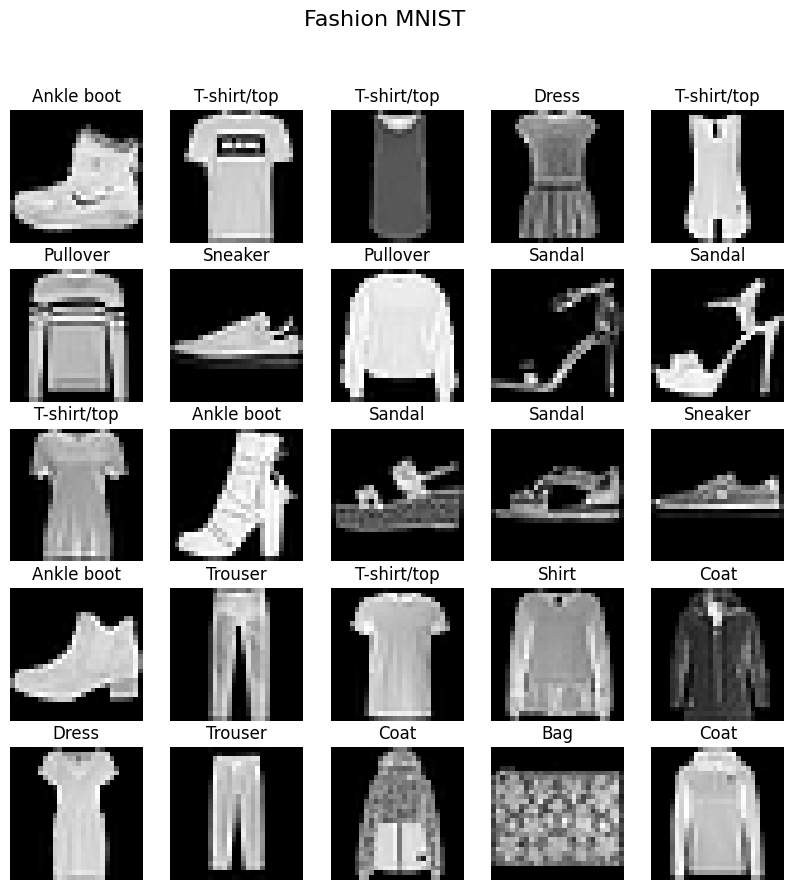

In [ ]:
# Plot sample images
plot_images(X, labels, y, 5, 5)

In [ ]:
# 2. Check the distribution of the classes
hist, bins = np.histogram(y, bins=10)
print(hist)

[7000 7000 7000 7000 7000 7000 7000 7000 7000 7000]


In [ ]:
# 3. Scale the data to the range [-1, 1]
X = ((X / 255.) - 0.5) * 2

### Train / Validation / Testing split

We will use a 80 / 20 split, with 20% of training split off for validation (16% of total).

In [ ]:
# split into train+validate / test
Xrv, Xt, yrv, yt = train_test_split(X, y, test_size=0.2, random_state=314)

# split further into train / validate
Xr, Xv, yr, yv = train_test_split(Xrv, yrv, test_size=0.2, random_state=314)

print(yr.shape, yv.shape, yt.shape)

(44800,) (11200,) (14000,)


### Train the model

In [ ]:
model = MLP.NeuralNetMLP(
    num_classes=10,
    num_features=Xr.shape[1],
    num_hidden=50,
    num_layers=1,
)

In [ ]:
epoch_loss, epoch_train_acc, epoch_valid_acc = \
    model.train(
        Xr, yr, Xv, yv,
        num_epochs=40,
        learning_rate=0.07
    )

Epoch 1/40 | Train Loss: 0.06 | Train Acc: 0.79 |Valid Loss: 0.06 | Valid Acc: 0.78
Epoch 2/40 | Train Loss: 0.05 | Train Acc: 0.82 |Valid Loss: 0.05 | Valid Acc: 0.81
Epoch 3/40 | Train Loss: 0.05 | Train Acc: 0.82 |Valid Loss: 0.05 | Valid Acc: 0.82
Epoch 4/40 | Train Loss: 0.05 | Train Acc: 0.84 |Valid Loss: 0.05 | Valid Acc: 0.84
Epoch 5/40 | Train Loss: 0.04 | Train Acc: 0.85 |Valid Loss: 0.04 | Valid Acc: 0.84
Epoch 6/40 | Train Loss: 0.04 | Train Acc: 0.85 |Valid Loss: 0.04 | Valid Acc: 0.85
Epoch 7/40 | Train Loss: 0.04 | Train Acc: 0.85 |Valid Loss: 0.04 | Valid Acc: 0.85
Epoch 8/40 | Train Loss: 0.04 | Train Acc: 0.86 |Valid Loss: 0.04 | Valid Acc: 0.85
Epoch 9/40 | Train Loss: 0.04 | Train Acc: 0.86 |Valid Loss: 0.04 | Valid Acc: 0.85
Epoch 10/40 | Train Loss: 0.04 | Train Acc: 0.86 |Valid Loss: 0.04 | Valid Acc: 0.85
Epoch 11/40 | Train Loss: 0.04 | Train Acc: 0.87 |Valid Loss: 0.04 | Valid Acc: 0.86
Epoch 12/40 | Train Loss: 0.04 | Train Acc: 0.87 |Valid Loss: 0.04 | Valid

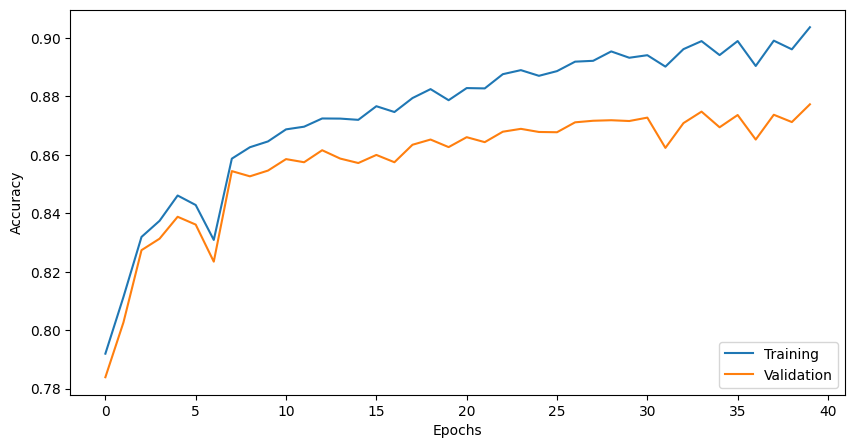

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
ax.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(loc='lower right')

plt.show()

This is not inspiring, but decent considering we are using a single hidden layer, a fixed learning rate, and a modest number of epochs.

We will revisit this in Question 7.



---


### Question 6

Now we'll make use of the regularization terms we have coded into the `train` function.  Let's set a small value for both and see what we get.

In [ ]:
model = MLP.NeuralNetMLP(
    num_classes=10,
    num_features=Xr.shape[1],
    num_hidden=50,
    num_layers=1,
    l1=0.0001,
    l2=0.0001
)

epoch_loss, epoch_train_acc, epoch_valid_acc = \
    model.train(
        Xr, yr, Xv, yv,
        num_epochs=40,
        learning_rate=0.02
    )

Epoch 1/40 | Train Loss: 0.07 | Train Acc: 0.74 |Valid Loss: 0.08 | Valid Acc: 0.73
Epoch 2/40 | Train Loss: 0.06 | Train Acc: 0.77 |Valid Loss: 0.07 | Valid Acc: 0.76
Epoch 3/40 | Train Loss: 0.06 | Train Acc: 0.79 |Valid Loss: 0.06 | Valid Acc: 0.78
Epoch 4/40 | Train Loss: 0.06 | Train Acc: 0.80 |Valid Loss: 0.06 | Valid Acc: 0.80
Epoch 5/40 | Train Loss: 0.05 | Train Acc: 0.81 |Valid Loss: 0.05 | Valid Acc: 0.80
Epoch 6/40 | Train Loss: 0.05 | Train Acc: 0.81 |Valid Loss: 0.05 | Valid Acc: 0.81
Epoch 7/40 | Train Loss: 0.05 | Train Acc: 0.82 |Valid Loss: 0.05 | Valid Acc: 0.82
Epoch 8/40 | Train Loss: 0.05 | Train Acc: 0.83 |Valid Loss: 0.05 | Valid Acc: 0.82
Epoch 9/40 | Train Loss: 0.05 | Train Acc: 0.83 |Valid Loss: 0.05 | Valid Acc: 0.82
Epoch 10/40 | Train Loss: 0.05 | Train Acc: 0.83 |Valid Loss: 0.05 | Valid Acc: 0.83
Epoch 11/40 | Train Loss: 0.05 | Train Acc: 0.84 |Valid Loss: 0.05 | Valid Acc: 0.83
Epoch 12/40 | Train Loss: 0.05 | Train Acc: 0.84 |Valid Loss: 0.05 | Valid

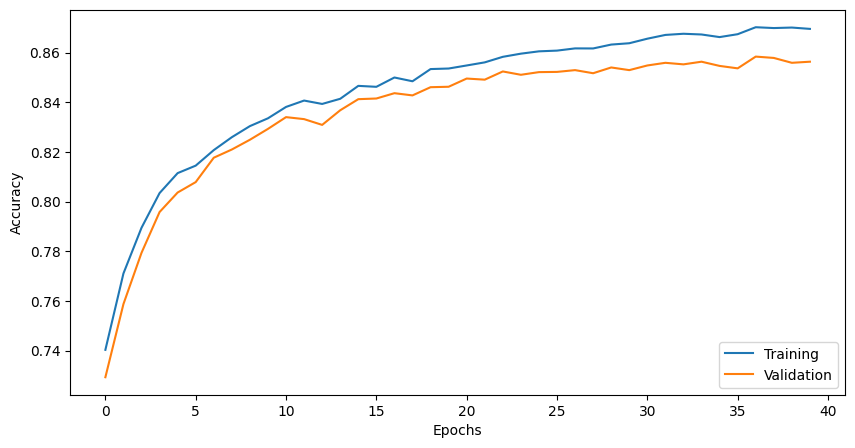

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
ax.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(loc='lower right')

plt.show()

Similar overall performance but anecdotally, it looks like the loss curve has smoothed out, and our training and validation scores are closer, as expected (regularization should improve our out-of-sample performance by not overfitting, even if slightly hurting our in-sample performance).  Without doing any hyperparameter selection, we also notice we're actually doing worse than without regularization, overall.



---


### Question 7

We'll now select more optimal hyperparameters using a primitive k-fold cross-validation scheme.  Specifically, we'll use the 80% cut of our dataset as training, and divide this into 5 "folds" of 20% each (16% of total).  With each fold, we will train on the training portion, and validate on the validation portion.  We'll do this 5-step process for *each possible combination of hyperparameters*, and then select the set of hyperparameters with the best average out-of-sample performance.  Finally, we will do a true test of these hyperparams on the held-out 20% test set.

We'd also like to test different numbers of hidden units, and, since our code implementation allows for it, different numbers of hidden layers.  This is an enormous number of combinations, so we'll be very judicious at first and see what part of the grid gives anywhere near better/worse performance.

In [ ]:
import itertools

In [ ]:
kfolds = 5
fold_size = Xrv.shape[0] // 5

hyperparams = {
    'l1': [0, 0.001],
    'l2': [0, 0.001],
    'learning_rate': [0.01, 0.05],
}

# Generate all possible combinations of hyperparameters
hyperparam_combinations = list(itertools.product(
    hyperparams['l1'],
    hyperparams['l2'],
    hyperparams['learning_rate']
))

N = len(hyperparam_combinations)

results = []

print(f"Total combinations: {N}")
print(f"Size of fold: {fold_size}")

# iterate over all possible hyperparams for this fold
for i, combo in enumerate(hyperparam_combinations):
    print(f'Combo ({i+1}/{N}): {combo}')

    l1, l2, lr = combo

    mce_avg, acc_avg = 0, 0
    for k in range(kfolds):
        # validation fold indices
        vx_start, vx_end = k * fold_size, (k+1) * fold_size

        # create validation and training sets
        Xv, yv = Xrv[vx_start:vx_end], yrv[vx_start:vx_end]
        Xr = np.concatenate([Xrv[:vx_start], Xrv[vx_end:]], axis=0)
        yr = np.concatenate([yrv[:vx_start], yrv[vx_end:]], axis=0)

        # create model and train
        model = MLP.NeuralNetMLP(
            num_classes=10,
            num_features=Xr.shape[1],
            num_hidden=50,
            num_layers=1,
            l1=l1,
            l2=l2
        )

        epoch_loss, epoch_train_acc, epoch_valid_acc = \
            model.train(
                Xr, yr, Xv, yv,
                num_epochs=30,
                learning_rate=lr,
                verbose=False,
                validate=False
            )

        # test on validation fold
        valid_mce, valid_acc = MLP.compute_mce_and_acc(model, Xv, yv)

        mce_avg += valid_mce
        acc_avg += valid_acc

        print(f'> Fold {k}: MCE: {valid_mce:0.3f}, Acc: {valid_acc:0.3f}')

    mce_avg /= kfolds
    acc_avg /= kfolds

    results.append([
        combo, [mce_avg, acc_avg]
    ])

Total combinations: 8
Size of fold: 11200
Combo (1/8): (0, 0, 0.01)
> Fold 0: MCE: 0.045, Acc: 0.842
> Fold 1: MCE: 0.043, Acc: 0.849
> Fold 2: MCE: 0.046, Acc: 0.837
> Fold 3: MCE: 0.045, Acc: 0.836
> Fold 4: MCE: 0.044, Acc: 0.847
Combo (2/8): (0, 0, 0.05)
> Fold 0: MCE: 0.038, Acc: 0.868
> Fold 1: MCE: 0.036, Acc: 0.873
> Fold 2: MCE: 0.039, Acc: 0.866
> Fold 3: MCE: 0.037, Acc: 0.866
> Fold 4: MCE: 0.037, Acc: 0.869
Combo (3/8): (0, 0.001, 0.01)
> Fold 0: MCE: 0.045, Acc: 0.841
> Fold 1: MCE: 0.043, Acc: 0.849
> Fold 2: MCE: 0.046, Acc: 0.836
> Fold 3: MCE: 0.045, Acc: 0.834
> Fold 4: MCE: 0.044, Acc: 0.848
Combo (4/8): (0, 0.001, 0.05)
> Fold 0: MCE: 0.037, Acc: 0.871
> Fold 1: MCE: 0.035, Acc: 0.876
> Fold 2: MCE: 0.039, Acc: 0.866
> Fold 3: MCE: 0.037, Acc: 0.866
> Fold 4: MCE: 0.036, Acc: 0.876
Combo (5/8): (0.001, 0, 0.01)
> Fold 0: MCE: 0.047, Acc: 0.839
> Fold 1: MCE: 0.045, Acc: 0.843
> Fold 2: MCE: 0.049, Acc: 0.825
> Fold 3: MCE: 0.048, Acc: 0.832
> Fold 4: MCE: 0.047, Ac

In [ ]:
results

[[(0, 0, 0.01),
  [np.float64(0.044781901281421746), np.float64(0.8422499999999999)]],
 [(0, 0, 0.05),
  [np.float64(0.037204091405624674), np.float64(0.8685357142857143)]],
 [(0, 0.001, 0.01),
  [np.float64(0.044881257163585674), np.float64(0.8418214285714285)]],
 [(0, 0.001, 0.05),
  [np.float64(0.036775871210494825), np.float64(0.8710000000000001)]],
 [(0.001, 0, 0.01),
  [np.float64(0.04704008225787333), np.float64(0.8355714285714285)]],
 [(0.001, 0, 0.05),
  [np.float64(0.04669670674390406), np.float64(0.8330714285714285)]],
 [(0.001, 0.001, 0.01),
  [np.float64(0.04755173700218526), np.float64(0.8357321428571428)]],
 [(0.001, 0.001, 0.05),
  [np.float64(0.0499939275781318), np.float64(0.8255892857142857)]]]

We can see the parameters $\alpha = 0$, $\beta = 0.001$, and $\eta = 0.05$ gave the best validation accuracy.  Let's train the model with those parameters on the full training set and then test it on the held-out set.

In [ ]:
model = MLP.NeuralNetMLP(
    num_classes=10,
    num_features=Xr.shape[1],
    num_hidden=50,
    num_layers=1,
    l1=0,
    l2=0.001
)

epoch_loss, epoch_train_acc, epoch_valid_acc = \
    model.train(
        Xrv, yrv, None, None,
        num_epochs=50,
        learning_rate=0.05,
        verbose=False,
        validate=False
    )

# test on validation fold
test_mce, test_acc = MLP.compute_mce_and_acc(model, Xt, yt)

In [ ]:
test_mce, test_acc

(np.float64(0.03488580216538011), np.float64(0.8766428571428572))

We have an accuracy of 87.6% on the held-out test set, which seems pretty decent for such a large dataset and simple model.  It is also close to our training performance which is reassuring.

### References

- Pattern Recognition and Machine Learning.  Christopher Bishop.  2006 (Chapter 5 - Neural Networks)
- MIT 6.867 (Machine Learning) Course Notes.  Tommi Jaakkola.  Fall 2016
- "Beginner's Guide to Neural Nets" September 2017 Blog post [https://stmorse.github.io/journal/Beginner-NN-Part-I.html](https://stmorse.github.io/journal/Beginner-NN-Part-I.html) by the author.